In [1]:
%%bash
git add my_toy_nn2.ipynb

In [140]:
%%bash
git commit -a -m "checkpoint"

[master 86444c8] checkpoint
 1 file changed, 247 insertions(+), 282 deletions(-)


In [2]:
1+1

2

In [3]:
%matplotlib inline

https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe

#  準備

* 正解がゼロとイチであるような100個のデータを作る
* ゼロの方よりイチのほうがすべての座標の平均が1.5大きい

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

In [2]:
X1 = torch.randn(1000, 50)
X2 = torch.randn(1000, 50) + 1.5
X3 = torch.randn(1000,50) + 3
X = torch.cat([X1, X2 , X3], dim=0)
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
Y3 = torch.zeros(1000 , 1)
Y = torch.cat([Y1, Y2, Y3], dim=0)

In [3]:
print(X.size())
print(Y.size())

torch.Size([3000, 50])
torch.Size([3000, 1])


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [6]:
ax1 = fig.add_subplot(111)

In [7]:
ax1.scatter(X1[:,0] , X1[:,2] , color = "yellow")

In [8]:
ax1.scatter(X2[:,0] , X2[:,2], color = "red")

In [9]:
ax1.scatter(X3[:,0] , X3[:,2] , color = "yellow")

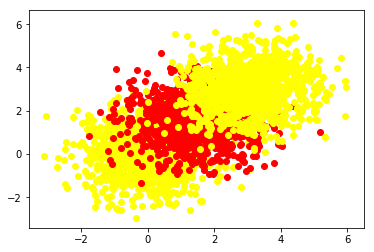

In [10]:
fig

In [11]:
X1.shape

torch.Size([1000, 50])

In [12]:
Y1.shape

torch.Size([1000, 1])

# ネットワークの定義

## main model


$    \text{PReLU}(x) = \max(0,x) + a * \min(0,x)$


In [13]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=50, out_features=50)
        self.relu1 = nn.ReLU()
        #self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        y = self.fc1(input_)
        y = self.relu1(y)        
        y = self.fc2(y)
        y = self.prelu(y)
        y = self.out(y)
        y = self.out_act(y)
        return y
    
    

## 線形変換 (値が0,1間に入らないのでcriteriaを評価できずエラーになる)

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 1)
        
    def forward(self, input_):
        y = self.fc1(input_)
        
        return y
    

##  線形変換＋sigmoid

In [14]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        y = self.out_act(a1)
        return y
    

## もともとのモデル

In [15]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    

In [16]:
model = Net()

In [17]:
print(model)

Net(
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2)
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (prelu): PReLU(num_parameters=1)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


# optimizer

## 学習測度はここで指定する

learning rate次第で学習の成否が大きく異なってくる

In [18]:
opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Binary cross entropy

ふたつの確率分布$p,q$があったときクロスエントロピーは

$$
H(p,q) =-{\rm E}_p[\log(q)]
$$

で定義される

説明変数のsample 
$$
x_0,x_1,\cdots , x_{N-1}
$$
に対して、正解が１であり、NNが確率$z$で１であると出力したとき、
正解の確率分布は


$$
 p(x) =
 \begin{cases}
        1 & x = 1\\
        0 & x = 0
 \end{cases}
$$
NNの導いた確率分布は
$$
 q(x) =
 \begin{cases}
        z & x = 1\\
        1-z & x = 0
 \end{cases}
$$
なのでクロスエントロピーは
$$
H(p,q) = -\log(z)
$$
であるが、
$$
H(q,p) = -z \log(1) - (1-z) \log(0)
$$
は計算できない

In [19]:
criterion = nn.BCELoss()

# my training

training modeに

In [20]:
model.train()

Net(
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2)
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (prelu): PReLU(num_parameters=1)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [21]:
def yield_batch(X , Y , batch_size):
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        yield x_batch  ,y_batch
    

In [22]:
batch_size = 50

In [23]:
def my_one_epoch(model , opt, criterion, X , Y , batch_size):
    batch_iterator = yield_batch(X , Y  , batch_size)
    for x_batch , y_batch in batch_iterator:

        ## loop decomposed

        ### zero grad
        #毎回gradをクリアしないといけない

        opt.zero_grad()

        ### Forward

        y_hat = model(x_batch)

        ### Compute diff

        loss = criterion(y_hat, y_batch)
        #print("loss : {}".format(loss))

        ### Compute gradients

        loss.backward()

        ### update weights

        opt.step()        

        ### loss 

        run_loss = float(loss.data.numpy())

    print(run_loss)

In [24]:
n_epochs = 20
for i in range(n_epochs):
    my_one_epoch(model , opt, criterion, X , Y , batch_size)

0.42836108803749084
0.38675469160079956
0.38040587306022644
0.36951231956481934
0.3592170774936676
0.36074742674827576
0.3468421697616577
0.35194942355155945
0.35672101378440857
0.3537641167640686
0.35244351625442505
0.36190304160118103
0.36007925868034363
0.3574187457561493
0.3631193935871124
0.3608333468437195
0.36761021614074707
0.36645686626434326
0.37193024158477783
0.3754085600376129


#  答え合わせ

In [25]:
y_model = model(X)

In [26]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [27]:
ax1 = fig.add_subplot(111)

In [28]:
Y.numpy()[:,0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [29]:
ax1.scatter(Y.numpy()[:,0] , y_model.detach().numpy()[:,0] , color = "red")

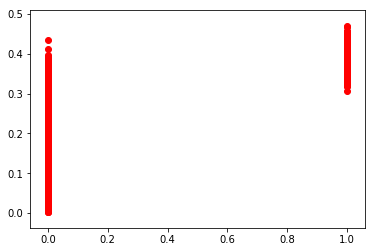

In [30]:
fig

In [99]:
tmp = y_model.detach().numpy()

# decomposed training

In [125]:
batch_iterator = yield_batch(X , Y  , batch_size)

In [46]:
x_batch , y_batch = next(batch_iterator)

## loop decomposed

### zero grad
毎回gradをクリアしないといけない

In [47]:
opt.zero_grad()

### Forward

In [48]:
y_hat = model(x_batch)

### Compute diff

In [50]:
loss = criterion(y_hat, y_batch)
print("loss : {}".format(loss))

loss : 0.7317055463790894


### Compute gradients

In [ ]:
loss.backward()

### update weights

In [ ]:
opt.step()        

### loss 

In [ ]:
run_loss = float(loss.data.numpy())

print(run_loss)

# original

def train_epoch(model, opt, criterion, batch_size=50):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)


        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [ ]:
e_losses = []
num_epochs = 200
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion)
plt.plot(e_losses)

In [ ]:
?Variable

In [ ]:
batch_size = 50

In [ ]:
losses = []
for beg_i in range(0, X.size(0), batch_size):
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = Variable(x_batch)
    y_batch = Variable(y_batch)

    opt.zero_grad()
    # (1) Forward
    y_hat = net(x_batch)
    # (2) Compute diff
    loss = criterion(y_hat, y_batch)
    # (3) Compute gradients
    loss.backward()
    # (4) update weights
    opt.step()        
    losses.append(loss.data.numpy())

In [ ]:
loss.backward?

In [ ]:
plt.plot(losses)

In [ ]:
print(losses)

In [ ]:
train_epoch(net, opt, criterion)

# option pricing imitation


In [36]:
import QuantLib as ql 

In [37]:
class cl_call:
    def price(self , spot_price, strike_price, maturity , is_american = True):
        if maturity <= 0:
            exercise_value = np.max([0 , spot_price - strike_price])
            return (exercise_value)
        dummy_strike = strike_price / spot_price
        

        option_type = ql.Option.Call
        payoff = ql.PlainVanillaPayoff(option_type, dummy_strike)
        
        maturity_date = self.calculation_date + int(365.0 * maturity)
        settlement = self.calculation_date
        if is_american:
            run_exercise = ql.AmericanExercise(settlement, maturity_date)
        else:
            run_exercise = ql.EuropeanExercise(maturity_date)
                
        
        american_option = ql.VanillaOption(payoff, run_exercise)
        if is_american:
            american_option.setPricingEngine(self.binomial_engine)
        else:

            american_option.setPricingEngine(ql.AnalyticEuropeanEngine(self.bsm_process))
                
        ql.Settings.instance().evaluationDate = self.calculation_date

        return (american_option.NPV() * spot_price)
        

    def __init__(self , volatility , dividend_rate , risk_free_rate  ,steps):
        day_count = ql.Actual365Fixed()
        #calendar = ql.UnitedStates()
        calendar = ql.Japan()
        self.calculation_date = ql.Date(8, 5, 2015)
        dummy_spot = 1
        
        self.spot_handle = ql.QuoteHandle(ql.SimpleQuote(1.0))

        ql.Settings.instance().evaluationDate = self.calculation_date


        self.flat_ts = ql.YieldTermStructureHandle(
            ql.FlatForward(self.calculation_date, risk_free_rate, day_count)
        )

        self.dividend_yield = ql.YieldTermStructureHandle(
            ql.FlatForward(self.calculation_date, dividend_rate, day_count)
        )

        #### volatility

        self.flat_vol_ts = ql.BlackVolTermStructureHandle(
            ql.BlackConstantVol(self.calculation_date, calendar, volatility, day_count)
        )

        #### BS framework

        self.bsm_process = ql.BlackScholesMertonProcess(self.spot_handle, 
                                                   self.dividend_yield, 
                                                   self.flat_ts, 
                                                   self.flat_vol_ts)


        self.binomial_engine = ql.BinomialVanillaEngine(self.bsm_process, "crr", steps)
        



In [38]:
spot_price = 127.62
volatility = 0.20 # the historical vols or implied vols
dividend_rate =  0.063
risk_free_rate = 0.001
maturity = 1
dt = 0.1

strike_price = 130

#steps = 200
pricer_steps = 100

#dt = maturity / steps

In [39]:
am_call = cl_call(volatility ,  dividend_rate ,  risk_free_rate , pricer_steps)

In [40]:
am_call.price(spot_price, strike_price, maturity)

6.431300819558227

In [26]:
am_call.price(130 , 100, 0.1 , True)

29.999999999999993

In [27]:
am_call.price(130 , 100 , 0.1,  False)

29.2046218778254

In [20]:
am_call.price(130 , 100 , 0.1 , True)

29.999999999999993

## creating training data

In [41]:
N = 1000


In [42]:
share_prices  = torch.rand(N, 1) * 1000

In [43]:
volatilities = torch.rand(N , 1) * 0.6 + 0.01

In [44]:
share_prices[0,0].item()

589.3565063476562

In [45]:
option_prices = [cl_call(volatilities[i , 0].item() ,  
                         dividend_rate ,  
                         risk_free_rate , 
                         pricer_steps).price(share_prices[i,0].item(), 
                                              strike_price, 
                                              maturity) for i in range(N)]

In [46]:
X = torch.cat([share_prices , volatilities] , dim = 1)

In [47]:
X.size()

torch.Size([1000, 2])

In [81]:
y = torch.tensor(option_prices)

In [82]:
y = y.view(-1, 1)

In [50]:
y.size()

torch.Size([1000, 1])

## define net

In [51]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
        
    def forward(self, input_):
        y = self.fc1(input_)
        
        return y
    

In [52]:
model = Net()

In [53]:
print(model)

Net(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)


## optimizer

In [54]:
opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

## define loss function
https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

In [55]:
criterion = nn.MSELoss()

## training

In [56]:
model.train()

Net(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)

In [84]:
def train_epoch(model, opt, criterion, X, Y , batch_size=50):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

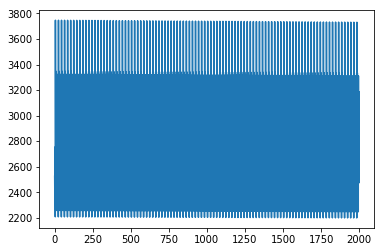

In [91]:
e_losses = []
num_epochs = 100
for e in range(num_epochs):
    e_losses += train_epoch(model, opt, criterion , X , y)
plt.plot(e_losses)

## check results

In [92]:
y_model = model(X)

In [93]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [94]:
ax1 = fig.add_subplot(111)

In [95]:
ax1.scatter(y.numpy()[:,0] , y_model.detach().numpy()[:,0] , color = "red")

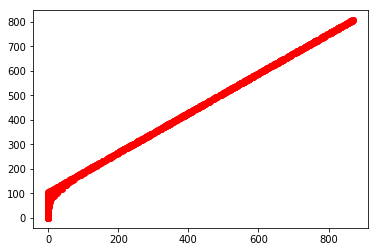

In [96]:
fig

## plot with plotnine

https://www.kaggle.com/princeashburton/an-intro-to-plotnine

In [81]:
import pandas as pd

In [85]:
from plotnine import *

ImportError: cannot import name 'factorial'